SCARlink requires scRNA-seq normalized relative counts in a [Seurat](https://satijalab.org/seurat/index.html) object and the corresponding multiomic scATAC-seq with non-binarized tile matrix in [ArchR](https://www.archrproject.com/index.html) object. The cell names should be in the same format in both the objects. The ArchR object needs to contain the TileMatrix with 500bp tiles. This R notebook demonstrates how the scRNA-seq and scATAC-seq objects need to be processed in order to run SCARlink. Here we use previously processed PBMC multiomic data from 10x Genomics.

In [2]:
library(Seurat)
library(ArchR)

In [3]:
scrna.file <- "/data/leslie/liuj11/src-test/scarlink-test-in/seurat-100c50g.rds"
scatac.file <- "/data/leslie/liuj11/src-test/scarlink-test-in/archr-100c"

In [4]:
scrna.object <- readRDS(scrna.file)
scatac.object <- loadArchRProject(scatac.file)

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

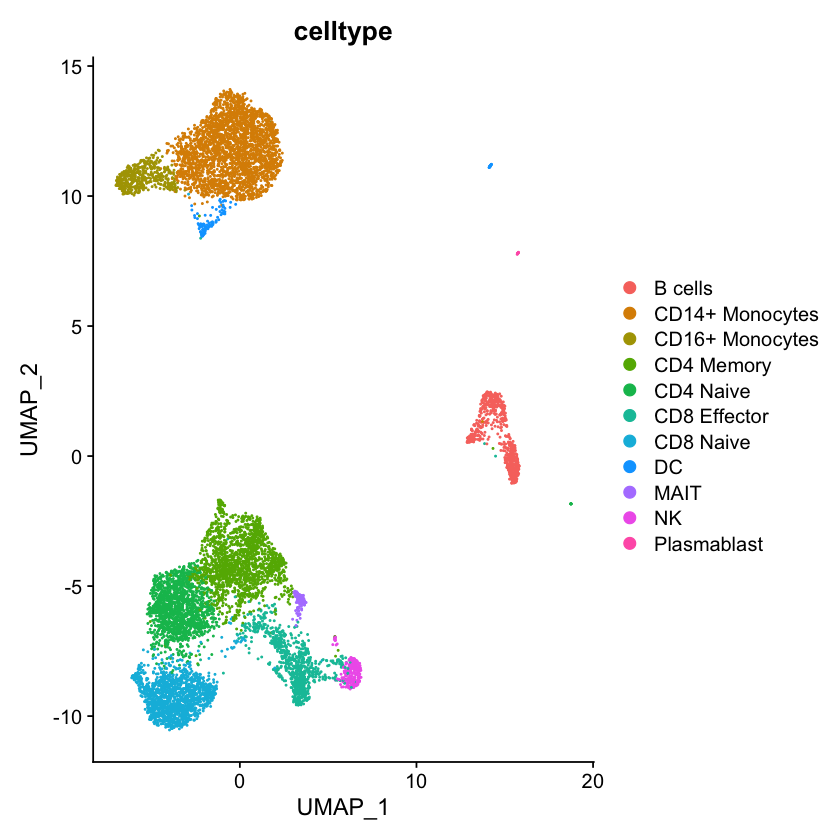

In [5]:
# Plot to check the cell type clusters
DimPlot(scrna.object, group.by="celltype")

### Check if cell names are in the same format in both `scrna.object` and `scatac.object`. If not, update the names to be in the same format.

In [11]:
# cell names in scrna.object
head(colnames(scrna.object))

[1] "pbmc_AAACAGCCAAGGAATC-1" "pbmc_AAACAGCCAATCCCTT-1"
[3] "pbmc_AAACAGCCAATGCGCT-1" "pbmc_AAACAGCCACACTAAT-1"
[5] "pbmc_AAACAGCCACCAACCG-1" "pbmc_AAACAGCCAGGATAAC-1"

In [7]:
# cell names in scatac.object
head(scatac.object$cellNames)

[1] "pbmc#AAACAGCCAAGGAATC-1" "pbmc#AAACAGCCAATCCCTT-1"
[3] "pbmc#AAACAGCCAATGCGCT-1" "pbmc#AAACAGCCACCAACCG-1"
[5] "pbmc#AAACAGCCAGGATAAC-1" "pbmc#AAACAGCCAGTAGGTG-1"

##### Update cell names in scrna.object to match the cell names in scatac.object

In [12]:
scrna.object <- RenameCells(scrna.object, new.names=gsub("_", "#", colnames(scrna.object)))

In [13]:
# new cell names in scrna.object match the format of cell names in scatac.object
head(colnames(scrna.object))

[1] "pbmc#AAACAGCCAAGGAATC-1" "pbmc#AAACAGCCAATCCCTT-1"
[3] "pbmc#AAACAGCCAATGCGCT-1" "pbmc#AAACAGCCACACTAAT-1"
[5] "pbmc#AAACAGCCACCAACCG-1" "pbmc#AAACAGCCAGGATAAC-1"

### Relative counts normalization scRNA-seq count matrix

In [14]:
scrna.object <- NormalizeData(scrna.object, normalization.method = "RC")

In [15]:
# save object
saveRDS(scrna.object, file = scrna.file)

### Check if scatac.object has non-binarized tile matrix. If not, then add tile matrix.

In [10]:
getAvailableMatrices(ArchRProj = scatac.object)

[1] "GeneExpressionMatrix" "GeneScoreMatrix"      "PeakMatrix"          
[4] "TileMatrix"

Here `scatac.object` already has the TileMatrix. Otherwise, it could have been generated using [`addTileMatrix(input=scatac.object, tileSize = 500, binarize=FALSE)`](https://www.archrproject.com/reference/addTileMatrix.html).

#### Check if available TileMatrix is binarized

Here the ArchR object contains a binarized tile matrix. `getMatrixFromProject` throws an error when trying to read a binarized matrix as a non-binarized matrix.

In [19]:
tm <- getMatrixFromProject(
  ArchRProj = scatac.object,
  useMatrix = 'TileMatrix',
  binarize = FALSE)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-fbae56bd6b89-Date-2023-06-26_Time-17-07-16.log
If there is an issue, please report to github with logFile!



ERROR: Error in .getMatFromArrow(ArrowFile = ArrowFile, featureDF = featureDF, : Sparse Matrix in Arrow is Binarized! Set binarize = TRUE to use matrix!


In [20]:
# Here the TileMatrix is not binarized, recompute the tile matrix as a non-binarized tile matrix.

scatac.object <- addTileMatrix(input=scatac.object, binarize=FALSE, tileSize = 500, force=TRUE)

ArchR logging to : ArchRLogs/ArchR-addTileMatrix-fbae2ddf1bdc-Date-2023-06-26_Time-17-11-40.log
If there is an issue, please report to github with logFile!

2023-06-26 17:11:40 : Batch Execution w/ safelapply!, 0 mins elapsed.

.createArrowGroup : Arrow Group already exists! Dropping Group from ArrowFile! This will take ~10-30 seconds!

.dropGroupsFromArrow : Initializing Temp ArrowFile

.dropGroupsFromArrow : Adding Metadata to Temp ArrowFile

.dropGroupsFromArrow : Adding SubGroups to Temp ArrowFile

.dropGroupsFromArrow : Move Temp ArrowFile to ArrowFile

2023-06-26 17:12:04 : Adding TileMatrix to pbmc for Chr (1 of 23)!, 0.127 mins elapsed.

2023-06-26 17:12:22 : Adding TileMatrix to pbmc for Chr (2 of 23)!, 0.424 mins elapsed.

2023-06-26 17:12:34 : Adding TileMatrix to pbmc for Chr (3 of 23)!, 0.637 mins elapsed.

2023-06-26 17:12:44 : Adding TileMatrix to pbmc for Chr (4 of 23)!, 0.788 mins elapsed.

2023-06-26 17:12:50 : Adding TileMatrix to pbmc for Chr (5 of 23)!, 0.89 mins e

In [21]:
# Check again 
tm <- getMatrixFromProject(
  ArchRProj = scatac.object,
  useMatrix = 'TileMatrix',
  binarize = FALSE)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-fbae4b49bbb9-Date-2023-06-26_Time-17-15-14.log
If there is an issue, please report to github with logFile!

2023-06-26 17:16:38 : Organizing colData, 1.388 mins elapsed.

2023-06-26 17:16:38 : Organizing rowData, 1.388 mins elapsed.

2023-06-26 17:16:38 : Organizing rowRanges, 1.388 mins elapsed.

2023-06-26 17:16:38 : Organizing Assays (1 of 1), 1.388 mins elapsed.

2023-06-26 17:16:38 : Constructing SummarizedExperiment, 1.388 mins elapsed.

2023-06-26 17:16:38 : Finished Matrix Creation, 1.397 mins elapsed.

